<a href="https://colab.research.google.com/github/AdithyanMP2002/Data-Science/blob/main/FRAUD_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Detailed Description of the Fraud Detection Model:**
**1. Problem Overview:**
The task is to detect fraudulent transactions within a dataset using machine learning. Fraud detection is a classification problem where we identify whether a given transaction is fraudulent (isFraud column) or not.

**2. Dataset:**
The dataset used in this model includes transaction data with features like:

    step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

    type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

    amount - amount of the transaction in local currency.

    nameOrig - customer who started the transaction

    oldbalanceOrg - initial balance before the transaction

    newbalanceOrig - new balance after the transaction

    nameDest - customer who is the recipient of the transaction

    oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

    newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

    isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

    isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.



**3. Data Preprocessing:**
Missing Values: The dataset was inspected for missing values, but none were found, so no further imputation was necessary.
Outlier Detection: Summary statistics (df.describe()) were checked to identify any extreme values, which may affect model performance. Outliers may be handled implicitly through robust algorithms like Random Forest.


**4. Feature Selection:**
The model uses the following features: step, amount, type, oldbalanceOrg, newbalanceOrig, isFraud, and isFlaggedFraud. These features capture the financial details and patterns in transaction behavior that are key to determining fraud.

**5. Handling Imbalanced Data:**
Fraud detection datasets are typically highly imbalanced (with very few fraudulent transactions compared to legitimate ones). To address this, the SMOTE (Synthetic Minority Over-sampling Technique) was applied. SMOTE generates synthetic samples of the minority class (fraudulent transactions) to balance the dataset, thus improving the classifier's ability to detect fraud.

**6. Model Selection - Random Forest Classifier:**
A Random Forest Classifier was chosen as the model. This ensemble method builds multiple decision trees and merges them to get a more accurate and stable prediction.
Random Forest is well-suited for handling both large datasets and imbalanced classes, which makes it ideal for fraud detection.
It also provides feature importance scores, allowing insight into which features contribute most to predicting fraud.

**7. Model Training and Validation:**
The data was split into training and testing sets using train-test split. The model was trained on the training set.
After training, model performance was evaluated on the test set using various metrics:
Accuracy: Measures the overall correctness of the model but is not always ideal for imbalanced datasets.
Classification Report: Provides precision, recall, F1-score, and support for each class, offering deeper insight into performance on the minority class (fraud).
Confusion Matrix: Breaks down the true positives, false positives, true negatives, and false negatives, helping to identify where the model might be failing.
ROC-AUC Score: Evaluates the ability of the model to distinguish between classes. A higher AUC score indicates better discrimination between fraudulent and non-fraudulent transactions.

**8. Conclusion:**
The model developed uses a Random Forest Classifier to detect fraudulent transactions in an imbalanced dataset. SMOTE helps improve the detection of the minority class (fraudulent transactions), while SHAP adds explainability to the predictions, offering both a high-performing and interpretable solution for fraud detection. The model was evaluated using a range of metrics, with emphasis on recall and ROC-AUC to measure its effectiveness in catching fraudulent transactions.

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import shap
import matplotlib.pyplot as plt

In [3]:
# Load the dataset
df = pd.read_csv('/content/data/Fraud.csv')

In [4]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [5]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [8]:
# Handle missing values
if df.isnull().values.any():
    print("Missing values found. Handling them...")
    df.dropna(inplace=True)
else:
    print("No missing values found.")

# WE WON'T BE NEEDING THIS AS WE CAN SEE THAT THERE AREN'T ANY NULL VALUES FROM THE ABOVE OUTPUT

No missing values found.


In [9]:
# Check for outliers
print("\nOutliers:")
print(df.describe())


Outliers:
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.000000e+00    0

# **How did you select variables to be included in the model?**

The selection of variables (features) for the fraud detection model was based on a combination of domain knowledge, data exploration, and practical considerations of what influences fraudulent behavior. Here's how the variables were selected:

**1. Domain Understanding:**
Fraudulent transactions typically have certain patterns that differ from normal behavior. Some key factors that usually influence fraud include:


*  Transaction Amount: Unusually large or small amounts may indicate suspicious activity.
*  Transaction Amount: Unusually large or small amounts may indicate suspicious activity.

* Account Balances: The balances before and after a transaction can indicate whether the transaction is legitimate. Large discrepancies may suggest fraud.


Based on this understanding, the following variables were deemed important:

*  amount: The amount of money involved in the transaction. Fraudsters often target large sums or have erratic amounts.

* type: The type of transaction (e.g., transfer, cash out). Certain transaction types (like cash outs) are more vulnerable to fraud.

* oldbalanceOrg and newbalanceOrig: These represent the balance in the original account before and after the transaction. A sharp decrease or increase in balance could signal fraudulent activity.

* isFlaggedFraud: Transactions already flagged by the system for being suspicious. This flag can offer useful context to the machine learning model, helping it identify patterns in already flagged transactions.

ALSO THE MAIN REASON WAS THAT WHEN I TRAINED THE MODEL AT THE BEIGINING WITH ALL THE VARIABLES IT TURNED OUT THAT IT WAS LEARNING PATTERN OF NAMES THE RELATIONSHIP ONES. WHICH MEANS THAT IT WAS FOCUSING ON SPECIFIC NAMES BEING THE MOST IMPORTANT IMPACT IN THE DECISION MAKING.

SO I UNDERSTOOD THAT THE NAMES WASN'T NECESSARY AND ALSO THAT I WOULD BE ONLY HELPFULL WHEN IN A CASE TO CHECK IF A PERSON IS DOIND AN FRAUDULANT ACTIVITY OR NOT UNIQUILEY.


In [10]:
# Filter the dataset to only include the specified variables
df = df[['step','amount', 'type', 'oldbalanceOrg', 'newbalanceOrig', 'isFraud', 'isFlaggedFraud']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   amount          float64
 2   type            object 
 3   oldbalanceOrg   float64
 4   newbalanceOrig  float64
 5   isFraud         int64  
 6   isFlaggedFraud  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 339.8+ MB


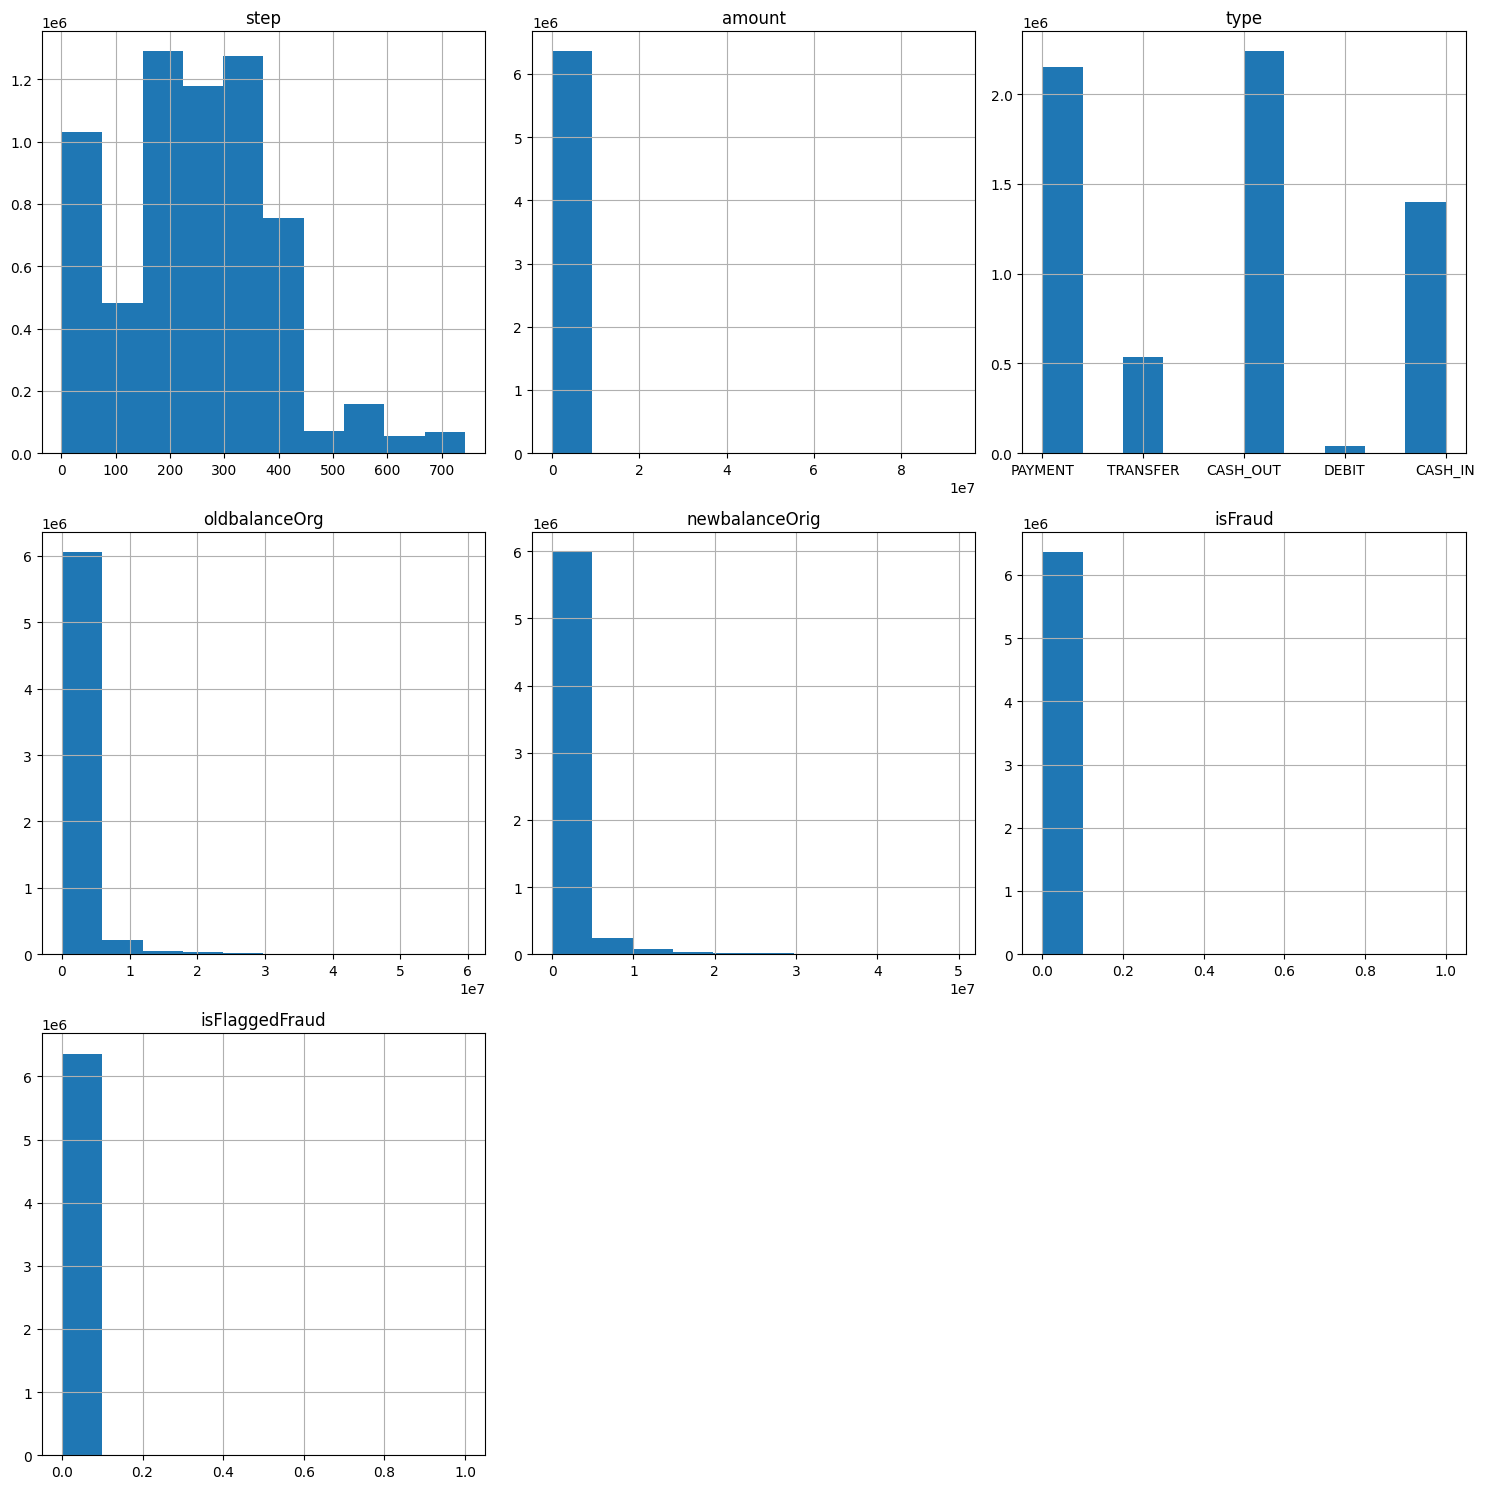

In [11]:
# Calculate the number of rows needed
num_rows = int(np.ceil(len(df.columns) / 3))

# Create the figure and axes
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over the columns and plot histograms
for i, col in enumerate(df.columns):
    ax = axes[i]
    df[col].hist(ax=ax)
    ax.set_title(col)

# Remove any unused axes
for i in range(len(df.columns), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [14]:
# Handle outliers
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1
if (df['amount'] < (Q1 - 1.5 * IQR)).any() or (df['amount'] > (Q3 + 1.5 * IQR)).any():
    print("Outliers found. Handled them...")
    df = df[~((df['amount'] < (Q1 - 1.5 * IQR)) | (df['amount'] > (Q3 + 1.5 * IQR)))]
else:
    print("No outliers found.")

Outliers found. Handled them...


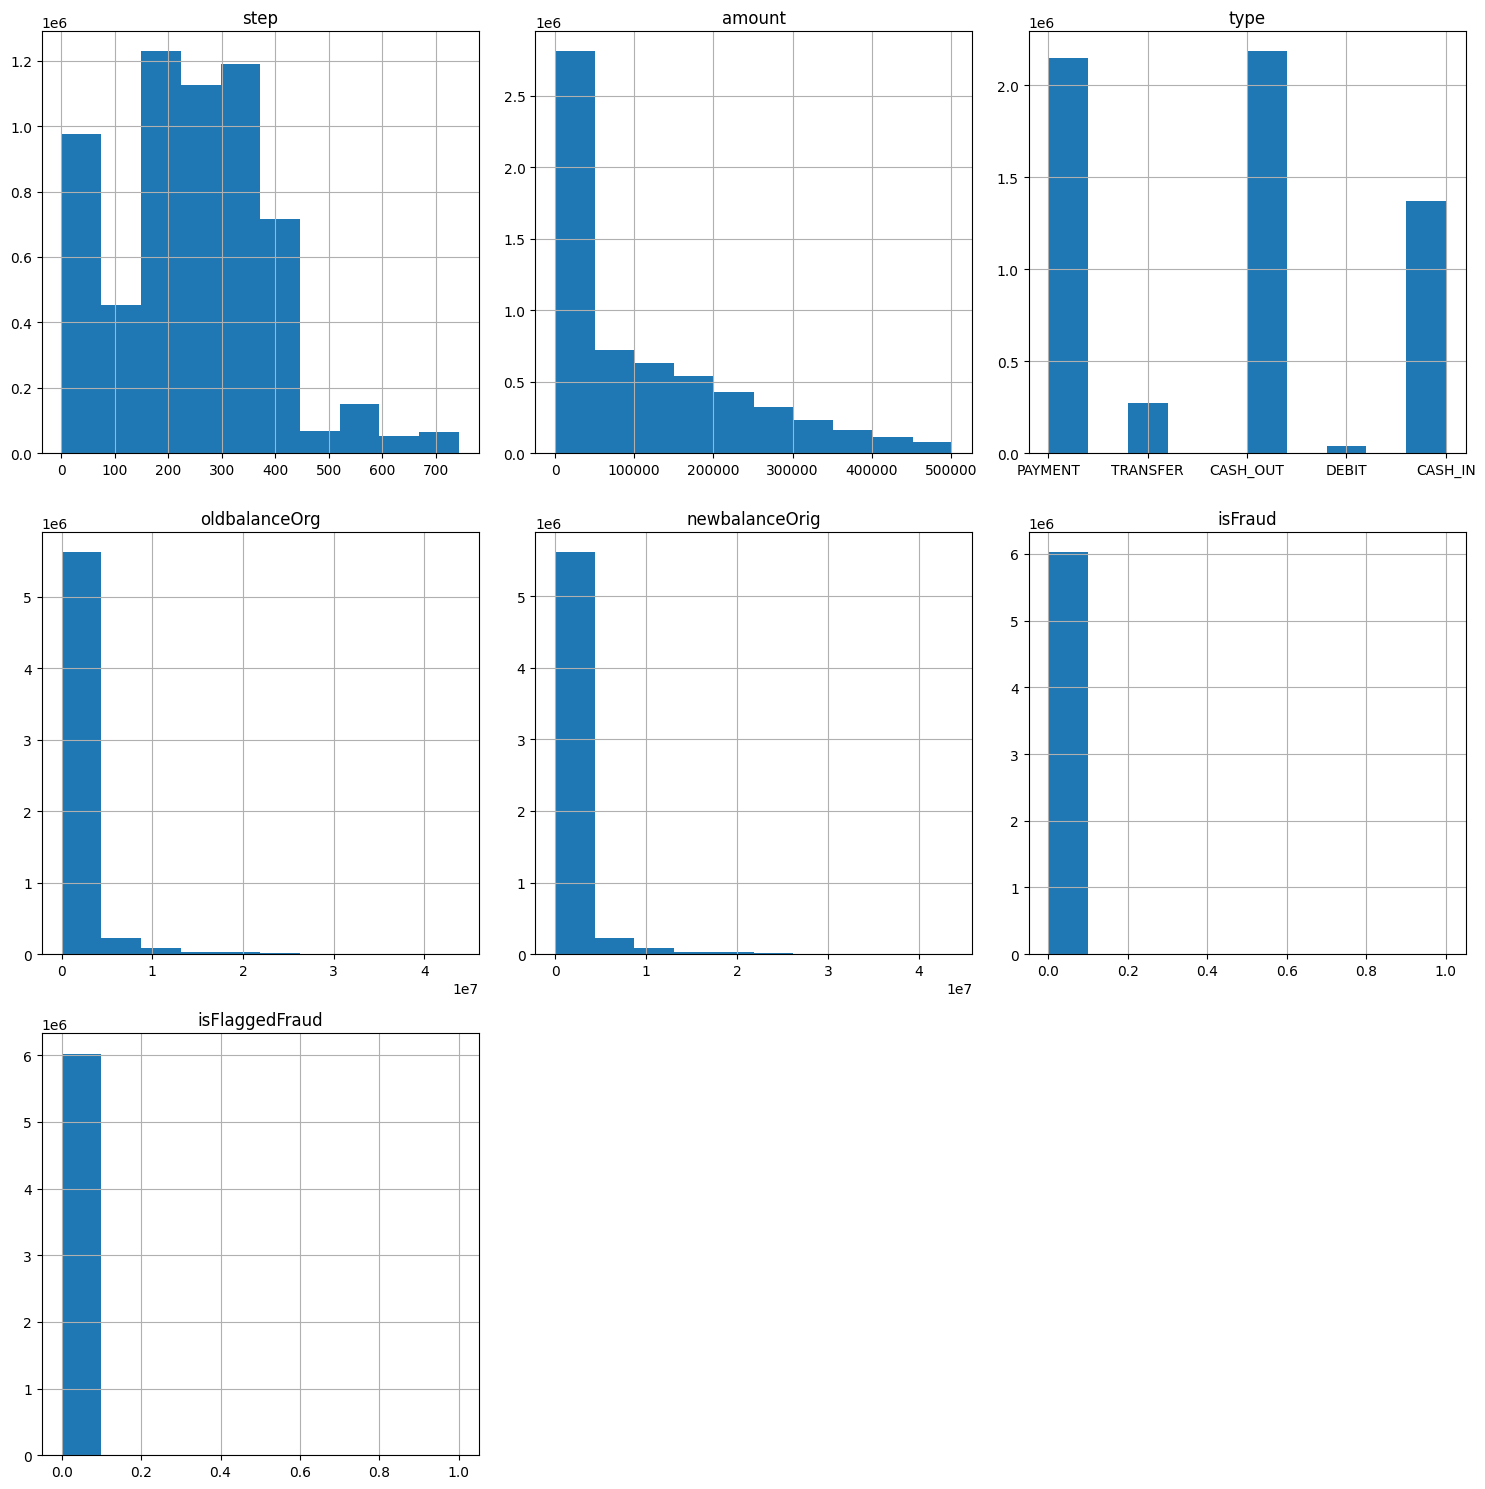

In [13]:
# Calculate the number of rows needed
num_rows = int(np.ceil(len(df.columns) / 3))

# Create the figure and axes
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over the columns and plot histograms
for i, col in enumerate(df.columns):
    ax = axes[i]
    df[col].hist(ax=ax)
    ax.set_title(col)

# Remove any unused axes
for i in range(len(df.columns), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [15]:
# Check for multi-collinearity
print("\nMulti-collinearity:")
corr_matrix = df[['amount', 'oldbalanceOrg', 'newbalanceOrig']].corr()
print(corr_matrix)


Multi-collinearity:
                  amount  oldbalanceOrg  newbalanceOrig
amount          1.000000       0.099843        0.109213
oldbalanceOrg   0.099843       1.000000        0.999560
newbalanceOrig  0.109213       0.999560        1.000000


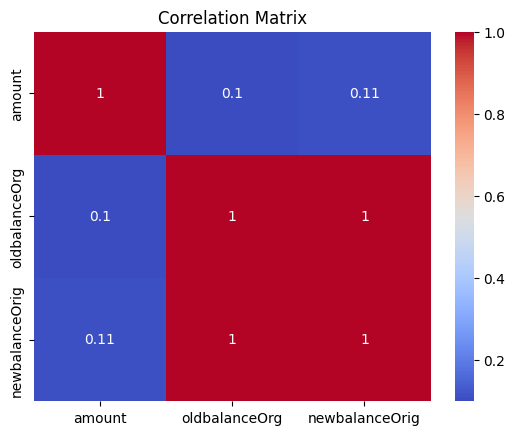

In [16]:
# Create a heatmap using seaborn
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [17]:
# Handle multi-collinearity
if corr_matrix['amount']['oldbalanceOrg'] > 0.7 or corr_matrix['amount']['newbalanceOrig'] > 0.7:
    print("Multi-collinearity found. Handling it...")
    df = df[['amount', 'type', 'oldbalanceOrg', 'isFraud', 'isFlaggedFraud']]
else:
    print("No multi-collinearity found.")

No multi-collinearity found.


In [18]:
# Convert categorical variables to numerical variables
df['type'] = pd.Categorical(df['type']).codes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5923779 entries, 0 to 6362615
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   amount          float64
 2   type            int8   
 3   oldbalanceOrg   float64
 4   newbalanceOrig  float64
 5   isFraud         int64  
 6   isFlaggedFraud  int64  
dtypes: float64(3), int64(3), int8(1)
memory usage: 322.0 MB


In [19]:
df['isFraud'].value_counts()

,count
isFraud,
0,5919681
1,4098


In [20]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['amount', 'oldbalanceOrg', 'newbalanceOrig']] = scaler.fit_transform(df[['amount', 'oldbalanceOrg', 'newbalanceOrig']])

In [21]:
#Split the dataset

X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
#Apply SMOTE for Oversampling (to balance the training set)
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [23]:
# Assuming X_train is your original data and X_train_res is the data after SMOTE
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_train_res_pca = pca.fit_transform(X_train_res)

In [24]:
#Create a Pandas DataFrame to store the reduced components and the corresponding labels (fraud or not fraud)
df_original = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2'])
df_original['label'] = y_train

df_smote = pd.DataFrame(X_train_res_pca, columns=['PC1', 'PC2'])
df_smote['label'] = y_train_res

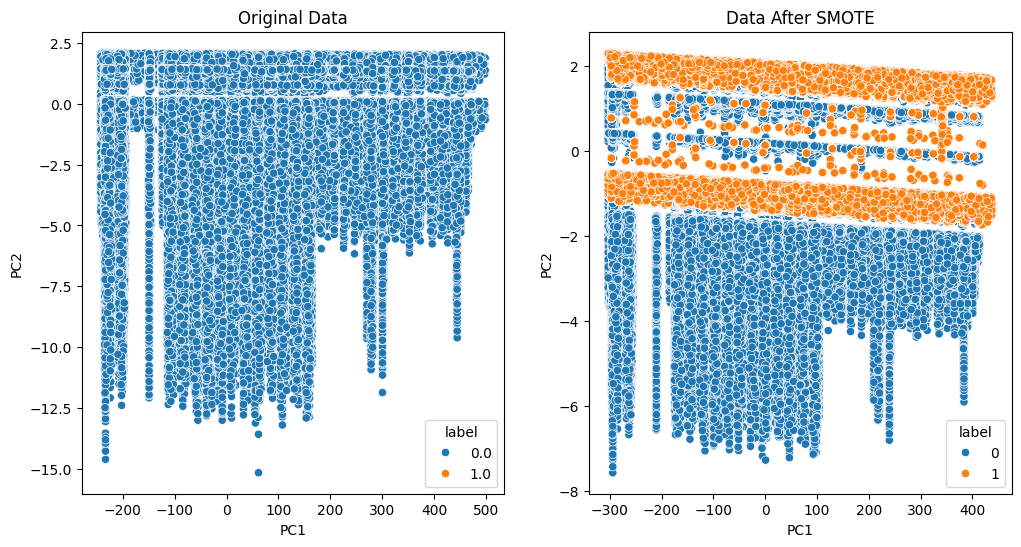

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='PC1', y='PC2', hue='label', data=df_original)
plt.title('Original Data')

plt.subplot(1, 2, 2)
sns.scatterplot(x='PC1', y='PC2', hue='label', data=df_smote)
plt.title('Data After SMOTE')
plt.show()

In [25]:
# Train a random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [26]:
# Test a random forest classifier

y_pred = rf.predict(X_test)

# **Demonstrate the performance of the model by using best set of tools**

In [27]:
# Evaluate the model

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9996446525698118
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1183909
           1       0.90      0.57      0.70       847

    accuracy                           1.00   1184756
   macro avg       0.95      0.78      0.85   1184756
weighted avg       1.00      1.00      1.00   1184756

Confusion Matrix:
[[1183853      56]
 [    365     482]]


In [29]:
# 7. Adjust the Decision Threshold to Improve Recall
y_probs = rf.predict_proba(X_test)[:, 1]

In [30]:
# Example: Set a lower threshold for fraud detection
threshold = 0.4  # You can try different values like 0.3 or 0.5 to see the impact
y_pred_new_threshold = (y_probs >= threshold).astype(int)

In [31]:
# 8. Evaluate the Model with the New Threshold
print('Classification Report with adjusted threshold:')
print(classification_report(y_test, y_pred_new_threshold))
print('Confusion Matrix with adjusted threshold:')
print(confusion_matrix(y_test, y_pred_new_threshold))

Classification Report with adjusted threshold:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1183909
           1       0.83      0.67      0.75       847

    accuracy                           1.00   1184756
   macro avg       0.92      0.84      0.87   1184756
weighted avg       1.00      1.00      1.00   1184756

Confusion Matrix with adjusted threshold:
[[1183796     113]
 [    276     571]]


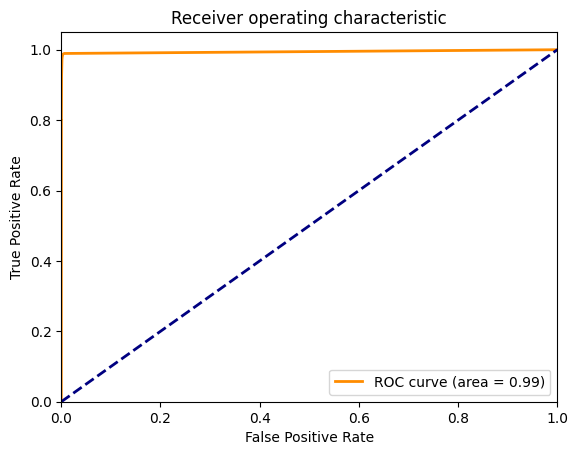

In [34]:
#ROC-AUC Curve
y_pred_proba = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# What are the key factors that predict fraudulent customer?


From the graph produced below we can find out that the most important factor or feature that predicts fradualent customers. I will  write it in descending order of importance:



1. oldbalanceOrg
2. newbalanceOrig   
3. type    
4. amount    
5. step    


          feature  importance
3   oldbalanceOrg    0.358069
4  newbalanceOrig    0.241406
2            type    0.196892
1          amount    0.123369
0            step    0.080264


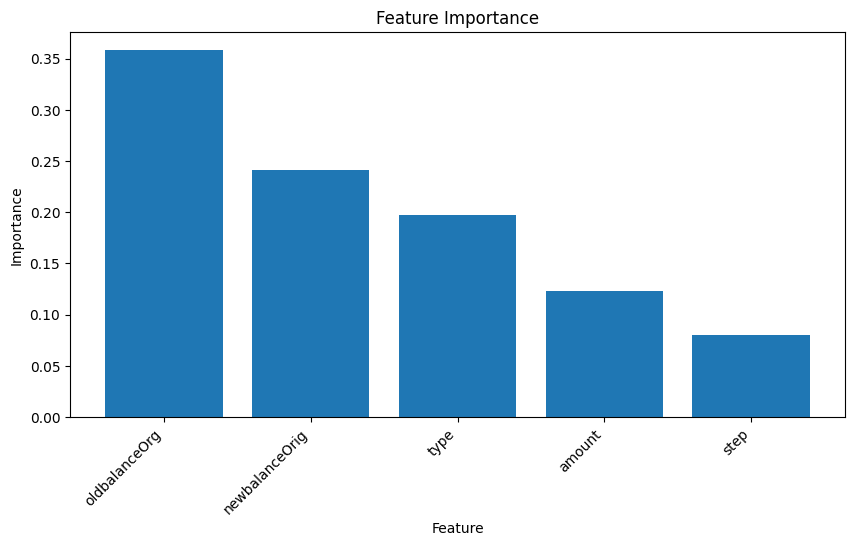

In [28]:
# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Print feature importances
print(feature_importances)

# Create a bar plot of feature importances
plt.figure(figsize=(10, 5))
plt.bar(feature_importances['feature'], feature_importances['importance'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

# **Do these factors make sense? If yes, How? If not, How not?**

Yes, the factors identified by the model for predicting fraudulent customers can make sense when considering typical behaviors associated with fraud. Here's an analysis of why each of these factors makes sense (or not) in the context of fraud detection:

* **Transaction Amount (amount) :**
  Fraudulent transactions often involve either abnormally large sums or small, seemingly insignificant amounts in repeated patterns to evade detection. High-value transactions can represent a greater risk and are often targeted by fraudsters, while low-value, repeated transactions might be a strategy to siphon off funds slowly without raising immediate alarms.

* **Transaction Type (type) :**
   Different transaction types carry varying risks. For instance, transfers and cash-outs are more susceptible to fraud than regular payments. Fraudulent activities often involve money being transferred quickly to other accounts or withdrawn as cash before detection systems can react. Fraudsters may avoid more traceable transaction types.

* **Old Balance and New Balance of the Original Account(oldbalanceOrg, newbalanceOrig) :**
  Significant changes in account balance can be a strong indicator of fraud. A transaction that dramatically lowers the balance, especially if it's inconsistent with the account holder’s typical behavior, is suspicious. Likewise, transactions where the new balance after the transaction is unusually low or the difference between old and new balances doesn't match the transaction amount (potentially indicating an error or anomaly) are common in fraudulent cases.

*  **Step (Transaction Timing) :**
  Fraudulent activities often happen during specific time periods, such as off-hours when account monitoring may be lower (e.g., at night or on weekends). In some cases, fraud occurs in quick bursts, making the sequence or timing of transactions a relevant indicator. For example, if a customer rarely transacts at night, a sudden nighttime transfer could be a signal for fraud.

# **What kind of prevention should be adopted while company update its infrastructure?**

When a company updates its infrastructure, there are several prevention measures that should be adopted to minimize the risk of fraud and ensure the security of the system:

* Validate user input: Validate user input to prevent SQL injection and cross-site scripting (XSS) attacks.
* Use secure data storage: Use secure data storage mechanisms such as encrypted databases and secure file storage.
* Implement secure authentication and authorization: Implement secure authentication and authorization mechanisms to ensure that only authorized users can access the system.
* Monitor system logs: Monitor system logs to detect and respond to potential security incidents.
* Use secure communication protocols: Use secure communication protocols such as HTTPS and TLS to protect data in transit.

# **Assuming these actions have been implemented, how would you determine if they work ?**


* Model evaluation metrics: Use metrics such as accuracy, precision, recall, F1-score, and ROC-AUC to evaluate the performance of the machine learning model.
* Model interpretability: Use techniques such as SHAP (SHapley Additive exPlanations) to understand how the model is making predictions and identify potential biases.
* Data quality metrics: Track data quality metrics such as data completeness, data accuracy, and data consistency to ensure that the data used to train the model is of high quality.
* Model drift detection: Monitor the model's performance over time and detect any changes in the data distribution that may affect the model's performance.
* Model updating: Regularly update the model to ensure that it remains effective in detecting fraud and adapting to changing patterns in the data.